<a href="https://colab.research.google.com/github/oreade16/EEG_GAN/blob/main/GAN_for_EEG_Hand_Movement.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Creation of a Generative Adversarial Network for EEG Hand Motor Signals

First, I will import the data.

In [2]:
# @title Data retrieval
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

Then, install the packages and load the data.


In [3]:
# @title Install packages (`nilearn`, `nimare`. `duecredit`), import `matplotlib` and set defaults
# install packages to visualize brains and electrode locations
!pip install nilearn --quiet
!pip install nimare --quiet
!pip install duecredit --quiet

from matplotlib import rcParams
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [4]:
# @title Data loading
import numpy as np

alldat = np.load(fname, allow_pickle=True)['dat']

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx.
dat1 = alldat[0][0]
dat2 = alldat[0][1]

print(dat1.keys())
print(dat2.keys())

dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])
dict_keys(['t_off', 'stim_id', 't_on', 'srate', 'V', 'scale_uv', 'locs', 'hemisphere', 'lobe', 'gyrus', 'Brodmann_Area'])


In [5]:
print(dat1)

{'t_off': array([ 13160,  19160,  25160,  31240,  37240,  43320,  49360,  55440,
        61520,  67600,  73680,  79680,  85680,  91720,  97760, 103760,
       109800, 115840, 121880, 127960, 134040, 140080, 146160, 152160,
       158160, 164160, 170240, 176320, 182320, 188320, 194320, 200400,
       206400, 212480, 218520, 224520, 230560, 236600, 242640, 248640,
       254640, 260720, 266760, 272800, 278840, 284840, 290880, 296880,
       302880, 308920, 314920, 321000, 327000, 333080, 339120, 345200,
       351240, 357320, 363360, 369440]), 'stim_id': array([12, 12, 12, 11, 12, 12, 12, 11, 11, 12, 12, 11, 11, 11, 12, 11, 11,
       11, 12, 12, 11, 11, 12, 11, 11, 12, 12, 12, 11, 11, 12, 11, 12, 12,
       12, 12, 11, 12, 11, 12, 12, 11, 11, 12, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 11, 12, 11, 11, 12, 11, 11], dtype=int32), 't_on': array([ 10160,  16160,  22160,  28240,  34240,  40320,  46360,  52440,
        58520,  64600,  70680,  76680,  82680,  88720,  94760, 100760,
       1

# Dataset info #

This is one of multiple ECoG datasets from Miller 2019, recorded in a clinical settings with a variety of tasks. Raw data and dataset paper are here:

https://exhibits.stanford.edu/data/catalog/zk881ps0522
https://www.nature.com/articles/s41562-019-0678-3

This particular dataset was originally described in this paper:

- Miller, Kai J., Gerwin Schalk, Eberhard E. Fetz, Marcel Den Nijs, Jeffrey G. Ojemann, and Rajesh PN Rao. "Cortical activity during motor execution, motor imagery, and imagery-based online feedback." Proceedings of the National Academy of Sciences (2010): 200913697. doi: [10.1073/pnas.0913697107](https://doi.org/10.1073/pnas.0913697107)

<br>

`dat1` and `dat2` are data from the two blocks performed in each subject. The first one was the actual movements, the second one was motor imagery. For the movement task, from the original dataset instructions:

*Patients performed simple, repetitive, motor tasks of hand (synchronous flexion and extension of all fingers, i.e., clenching and releasing a fist at a self-paced rate of ~1-2 Hz) or tongue (opening of mouth with protrusion and retraction of the tongue, i.e., sticking the tongue in and out, also at ~1-2 Hz). These movements were performed in an interval-based manner, alternating between movement and rest, and the side of move- ment was always contralateral to the side of cortical grid placement.*

<br>

For the imagery task, from the original dataset instructions:

*Following the overt movement experiment, each subject performed an imagery task, imagining making identical movement rather than executing the movement. The imagery was kinesthetic rather than visual (“imagine yourself performing the actions like you just did”; i.e., “don’t imagine what it looked like, but imagine making the motions”).*

<br>

Sample rate is always 1000Hz, and the ECoG data has been notch-filtered at 60, 120, 180, 240 and 250Hz, followed by z-scoring across time and conversion to float16 to minimize size. Please convert back to float32 after loading the data in the notebook, to avoid unexpected behavior.

Both experiments:
* `dat['V']`: continuous voltage data (time by channels)
* `dat['srate']`: acquisition rate (1000 Hz). All stimulus times are in units of this.
* `dat['t_on']`: time of stimulus onset in data samples
* `dat['t_off']`: time of stimulus offset, always 400 samples after `t_on`
* `dat['stim_id`]: identity of stimulus (11 = tongue, 12 = hand), real or imaginary stimulus
* `dat['scale_uv']`: scale factor to multiply the data values to get to microvolts (uV).
* `dat['locs`]`: 3D electrode positions on the brain surface

In [6]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = dat1['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

In [7]:
# quick way to get broadband power in time-varying windows
from scipy import signal

# pick subject 0 and experiment 0 (real movements)
dat1 = alldat[0][0]

# V is the voltage data
V = dat1['V'].astype('float32')

# high-pass filter above 50 Hz
b, a = signal.butter(3, [50], btype='high', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# compute smooth envelope of this signal = approx power
V = np.abs(V)**2
b, a = signal.butter(3, [10], btype='low', fs=1000)
V = signal.filtfilt(b, a, V, 0)

# normalize each channel so its mean power is 1
V = V/V.mean(0)

In [8]:
# average the broadband power across all tongue and hand trials
nt, nchan = V.shape
nstim = len(dat1['t_on'])

trange = np.arange(0, 2000)
ts = dat1['t_on'][:, np.newaxis] + trange
V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))
print(V_epochs.shape)

V_tongue = (V_epochs[dat1['stim_id'] == 11]).mean(0)
V_hand = (V_epochs[dat1['stim_id'] == 12]).mean(0)

(60, 2000, 46)


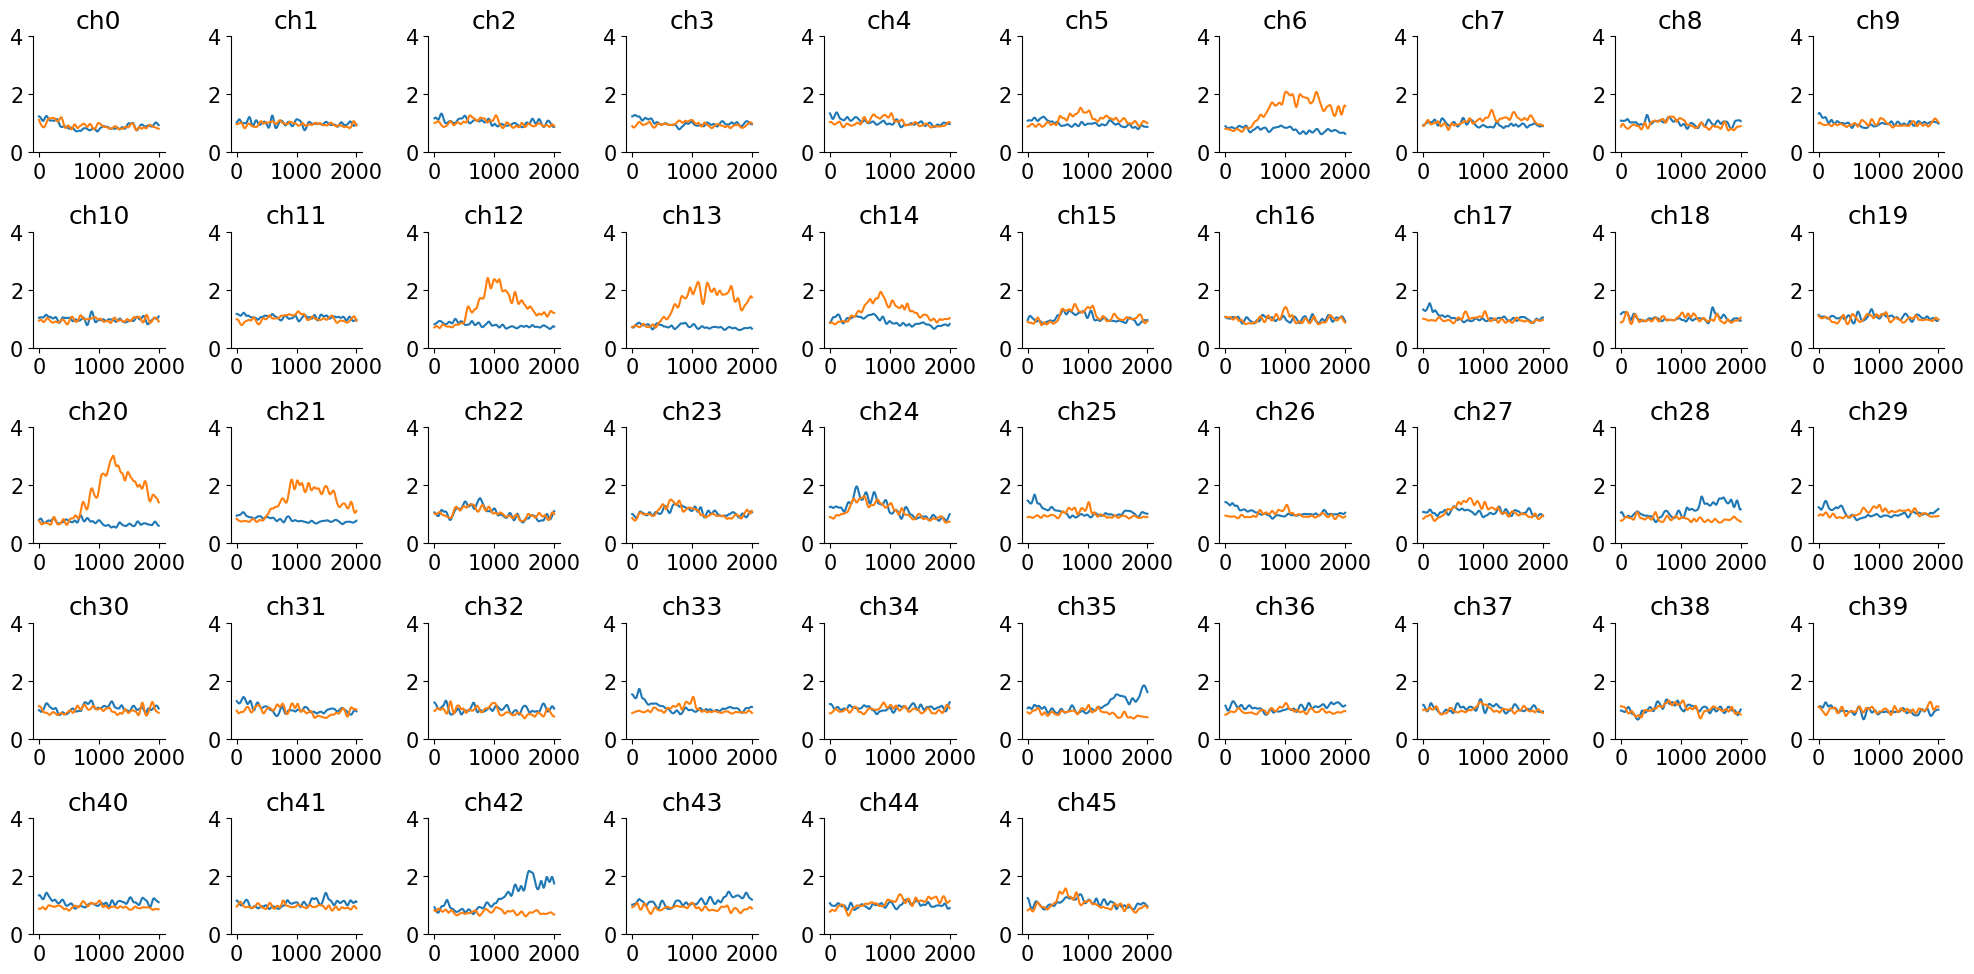

In [9]:
# let's find the electrodes that distinguish tongue from hand movements
# note the behaviors happen some time after the visual cue

plt.figure(figsize=(20, 10))
for j in range(46):
  ax = plt.subplot(5, 10, j+1)
  plt.plot(trange, V_tongue[:, j])
  plt.plot(trange, V_hand[:, j])
  plt.title('ch%d'%j)
  plt.xticks([0, 1000, 2000])
  plt.ylim([0, 4])
plt.show()

In [10]:
keys = {"V","srate","t_on","t_off","stim_id","scale_uv","locs"}

print(dat1.items())

dict_items([('t_off', array([ 13160,  19160,  25160,  31240,  37240,  43320,  49360,  55440,
        61520,  67600,  73680,  79680,  85680,  91720,  97760, 103760,
       109800, 115840, 121880, 127960, 134040, 140080, 146160, 152160,
       158160, 164160, 170240, 176320, 182320, 188320, 194320, 200400,
       206400, 212480, 218520, 224520, 230560, 236600, 242640, 248640,
       254640, 260720, 266760, 272800, 278840, 284840, 290880, 296880,
       302880, 308920, 314920, 321000, 327000, 333080, 339120, 345200,
       351240, 357320, 363360, 369440])), ('stim_id', array([12, 12, 12, 11, 12, 12, 12, 11, 11, 12, 12, 11, 11, 11, 12, 11, 11,
       11, 12, 12, 11, 11, 12, 11, 11, 12, 12, 12, 11, 11, 12, 11, 12, 12,
       12, 12, 11, 12, 11, 12, 12, 11, 11, 12, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 11, 12, 11, 11, 12, 11, 11], dtype=int32)), ('t_on', array([ 10160,  16160,  22160,  28240,  34240,  40320,  46360,  52440,
        58520,  64600,  70680,  76680,  82680,  88720,  94760, 

I have decided to use a for loop to get the dictionary elements

In [11]:
import pandas as pd


In [12]:
dat1.pop('srate',1000)
print(dat1)

{'t_off': array([ 13160,  19160,  25160,  31240,  37240,  43320,  49360,  55440,
        61520,  67600,  73680,  79680,  85680,  91720,  97760, 103760,
       109800, 115840, 121880, 127960, 134040, 140080, 146160, 152160,
       158160, 164160, 170240, 176320, 182320, 188320, 194320, 200400,
       206400, 212480, 218520, 224520, 230560, 236600, 242640, 248640,
       254640, 260720, 266760, 272800, 278840, 284840, 290880, 296880,
       302880, 308920, 314920, 321000, 327000, 333080, 339120, 345200,
       351240, 357320, 363360, 369440]), 'stim_id': array([12, 12, 12, 11, 12, 12, 12, 11, 11, 12, 12, 11, 11, 11, 12, 11, 11,
       11, 12, 12, 11, 11, 12, 11, 11, 12, 12, 12, 11, 11, 12, 11, 12, 12,
       12, 12, 11, 12, 11, 12, 12, 11, 11, 12, 11, 11, 11, 11, 11, 12, 12,
       12, 12, 11, 12, 11, 11, 12, 11, 11], dtype=int32), 't_on': array([ 10160,  16160,  22160,  28240,  34240,  40320,  46360,  52440,
        58520,  64600,  70680,  76680,  82680,  88720,  94760, 100760,
       1

In [13]:
data_items = dat1.items()
data1 = list(data_items)
data1 = pd.DataFrame.from_dict(data1,orient='columns')
print(data1)
df1 = pd.DataFrame(columns=data1[0])


               0                                                  1
0          t_off  [13160, 19160, 25160, 31240, 37240, 43320, 493...
1        stim_id  [12, 12, 12, 11, 12, 12, 12, 11, 11, 12, 12, 1...
2           t_on  [10160, 16160, 22160, 28240, 34240, 40320, 463...
3              V  [[1.113, 0.595, 0.2395, 1.161, 0.507, 1.755, -...
4       scale_uv  [48.769698129802485, 52.42750508796776, 61.506...
5           locs  [[-26.453523118864688, 39.98872529190197, 42.6...
6     hemisphere  [Left Cerebrum, Left Cerebrum, Left Cerebrum, ...
7           lobe  [Frontal Lobe, Frontal Lobe, Frontal Lobe, Fro...
8          gyrus  [Superior Frontal Gyrus, Superior Frontal Gyru...
9  Brodmann_Area  [Brodmann area 8, Brodmann area 8, Brodmann ar...


In [14]:
print(data1[1][5].shape)

(46, 3)


In [15]:
import numpy as np

df1['t_off']=(np.ndarray.tolist(data1[1][0]))
df1['stim_id']=(np.ndarray.tolist(data1[1][1]))
df1['t_on']=(np.ndarray.tolist(data1[1][2]))
df1['V'] = (np.ndarray.tolist(V_epochs))
df1['scale_uv'] = 1000
df1 = df1[['t_on','t_off','stim_id','V']]

options = [12]

df1 = df1[df1['stim_id'].isin(options)]

df1

,t_on,t_off,stim_id,V
0,10160,13160,12,"[[1.0323982370946092, 2.08178703239221, 0.7947..."
1,16160,19160,12,"[[0.9199763429158107, 0.9021235955044188, 1.04..."
2,22160,25160,12,"[[0.8091475251501186, 2.0510483699389765, 1.02..."
4,34240,37240,12,"[[1.2287817321672492, 0.5835377240490394, 1.47..."
5,40320,43320,12,"[[1.233006080572201, 1.4110651403091259, 1.182..."
6,46360,49360,12,"[[1.323768169812856, 0.6822142899287283, 1.063..."
9,64600,67600,12,"[[1.098892588612584, 0.9117922940449174, 0.759..."
10,70680,73680,12,"[[0.623185655189541, 1.0551187745106796, 0.989..."
14,94760,97760,12,"[[0.35549499224158054, 0.7515938356918287, 0.6..."
18,118880,121880,12,"[[0.8548821939009296, 1.004367096899928, 0.755..."


In [16]:
df1['V'][0]=[list(x) for x in zip(*df1['V'][0])]

In [17]:
for i in df1.index:
  if i != 0:
    df1['V'][i]=[list(x) for x in zip(*df1['V'][i])]

df1


<ipython-input-17-05da98085ecd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['V'][i]=[list(x) for x in zip(*df1['V'][i])]
<ipython-input-17-05da98085ecd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['V'][i]=[list(x) for x in zip(*df1['V'][i])]
<ipython-input-17-05da98085ecd>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['V'][i]=[list(x) for x in zip(*df1['V'][i])]
<ipython-input-17-05da98085ecd>:3: SettingWithCop

,t_on,t_off,stim_id,V
0,10160,13160,12,"[[1.0323982370946092, 1.0325200326388648, 1.03..."
1,16160,19160,12,"[[0.9199763429158107, 0.9212454420355957, 0.92..."
2,22160,25160,12,"[[0.8091475251501186, 0.8079178152084624, 0.80..."
4,34240,37240,12,"[[1.2287817321672492, 1.2194790680470802, 1.21..."
5,40320,43320,12,"[[1.233006080572201, 1.25428987993827, 1.27637..."
6,46360,49360,12,"[[1.323768169812856, 1.2957610549770107, 1.268..."
9,64600,67600,12,"[[1.098892588612584, 1.1202784814811984, 1.141..."
10,70680,73680,12,"[[0.623185655189541, 0.6234065847806287, 0.623..."
14,94760,97760,12,"[[0.35549499224158054, 0.3669573246949944, 0.3..."
18,118880,121880,12,"[[0.8548821939009296, 0.832363435612121, 0.810..."


In [18]:
import torch
for i in df1.index:
    df1['V'][i]=torch.FloatTensor(df1['V'][i])
df1


<ipython-input-18-9231795da390>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['V'][i]=torch.FloatTensor(df1['V'][i])
<ipython-input-18-9231795da390>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['V'][i]=torch.FloatTensor(df1['V'][i])
<ipython-input-18-9231795da390>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['V'][i]=torch.FloatTensor(df1['V'][i])
<ipython-input-18-9231795da390>:3: SettingWithCopyWarning: 
A value

,t_on,t_off,stim_id,V
0,10160,13160,12,"[[tensor(1.0324), tensor(1.0325), tensor(1.032..."
1,16160,19160,12,"[[tensor(0.9200), tensor(0.9212), tensor(0.922..."
2,22160,25160,12,"[[tensor(0.8091), tensor(0.8079), tensor(0.806..."
4,34240,37240,12,"[[tensor(1.2288), tensor(1.2195), tensor(1.210..."
5,40320,43320,12,"[[tensor(1.2330), tensor(1.2543), tensor(1.276..."
6,46360,49360,12,"[[tensor(1.3238), tensor(1.2958), tensor(1.268..."
9,64600,67600,12,"[[tensor(1.0989), tensor(1.1203), tensor(1.141..."
10,70680,73680,12,"[[tensor(0.6232), tensor(0.6234), tensor(0.623..."
14,94760,97760,12,"[[tensor(0.3555), tensor(0.3670), tensor(0.379..."
18,118880,121880,12,"[[tensor(0.8549), tensor(0.8324), tensor(0.810..."


In [19]:

x = df1['V'][0]
print(x.shape)


torch.Size([46, 2000])


## Building a Simple GAN From Scratch

In [20]:
import math
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


In [21]:
train_data_length = 2000
train_data = torch.zeros((train_data_length, 2))
train_data[:, 0] = torch.arange(2000)
train_data[:, 1] = df1['V'][0][1]
train_labels = torch.zeros(train_data_length)
train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]


In [22]:
training_data = df1['V'][0]

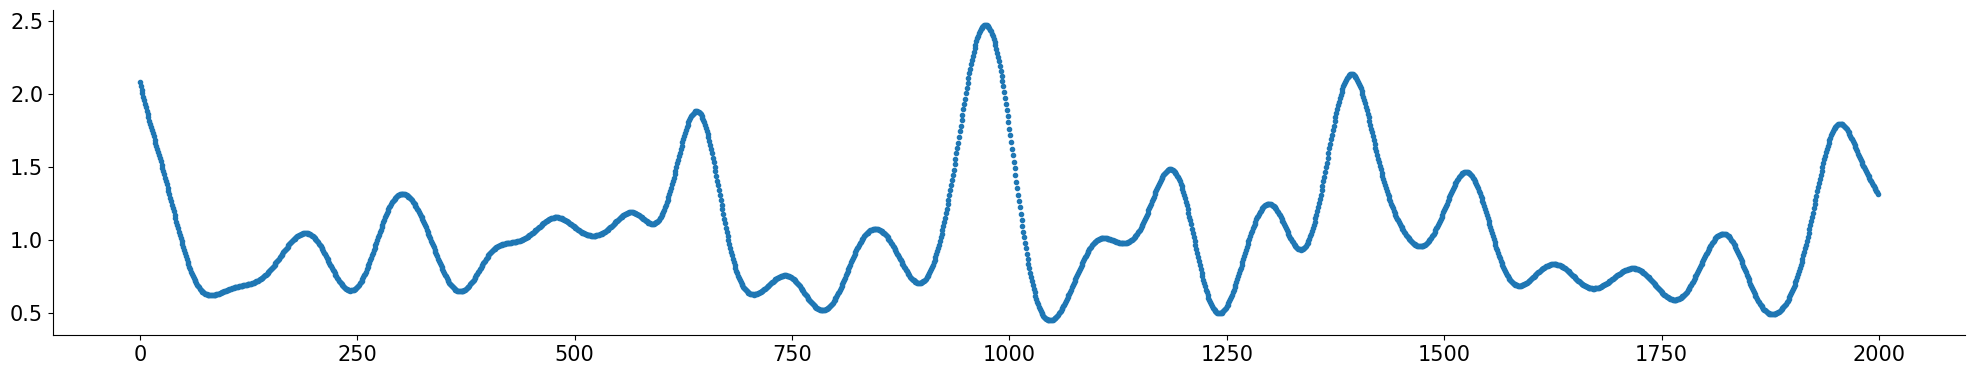

In [23]:
plt.plot(torch.arange(2000), train_data[:,1 ],'.')

In [24]:
batch_size = 40
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)

In [53]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_1 = nn.Conv1d(in_channels=1,out_channels=50,kernel_size=9,padding=4)
        self.linear = nn.Linear(2000,1536)
        self.conv_2 = nn.Conv1d(in_channels=50,out_channels=50,kernel_size=9,padding=4,stride=1)
        self.conv_3 = nn.Conv1d(in_channels=50,out_channels=50,kernel_size=9,padding=4,stride=2)
        self.lrelu = nn.LeakyReLU(0.2)
        self.linear_2 = nn.Linear(750,1)
        self.instancenorm = nn.InstanceNorm1d(num_features=50)
        self.avgpool = nn.AvgPool1d(kernel_size=2,stride=2)



    def forward(self, x):
      x = x.view(46,1,2000)
      x = self.conv_1(x)
      x = self.conv_2(x)
      x = self.instancenorm(x)
      x = self.lrelu(x)

      x = self.conv_2(x)
      x = self.instancenorm(x)
      x = self.lrelu(x)
      x = self.avgpool(x)


      x = self.conv_2(x)
      x = self.instancenorm(x)
      x = self.lrelu(x)

      x = self.conv_2(x)
      x = self.instancenorm(x)
      x = self.lrelu(x)
      x = self.avgpool(x)

      x = self.conv_2(x)

      x = self.instancenorm(x)
      x = self.lrelu(x)

      x = self.conv_2(x)
      x = self.instancenorm(x)
      x = self.lrelu(x)
      x = self.avgpool(x)

      x = self.conv_2(x)

      x = self.instancenorm(x)
      x = self.lrelu(x)

      x = self.conv_2(x)
      x = self.instancenorm(x)
      x = self.lrelu(x)
      x = self.avgpool(x)


      x = self.conv_2(x)

      x = self.instancenorm(x)
      x = self.lrelu(x)

      x = self.conv_2(x)
      x = self.instancenorm(x)
      x = self.lrelu(x)
      x = self.avgpool(x)



      x = self.conv_2(x)
      x = self.instancenorm(x)
      x = self.lrelu(x)

      x = self.conv_2(x)
      x = self.instancenorm(x)
      x = self.lrelu(x)
      x = self.avgpool(x)


      x = self.conv_2(x)
      x = self.instancenorm(x)
      x = self.lrelu(x)

      x = self.conv_2(x)
      x = self.instancenorm(x)
      x = self.lrelu(x)
      x = self.avgpool(x)


      x = x.view(46,750)
      x = self.linear_2(x)



      return x.reshape(46)

In [26]:
critic = Discriminator()


In [27]:
latent_space_vector = torch.rand(200,1)

In [28]:
import torchvision.transforms as transforms

In [59]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_initial = nn.ConvTranspose1d(in_channels=200,out_channels=50,kernel_size=9,padding=4)
        self.conv_9 = nn.ConvTranspose1d(in_channels=50,out_channels=50,kernel_size=9,padding=4)
        self.upsample = nn.Upsample(scale_factor=2)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm1d(num_features=50,affine=True)
        self.lrelu = nn.LeakyReLU(0.5)
        self.linear_2 = nn.Linear(3200,2000)



    def forward(self, x):
      x = self.conv_initial(x)
      x = self.lrelu(x)
      x = x.view(46,50,1)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)


      x = self.upsample(x)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)

      x = self.upsample(x)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)

      x = self.upsample(x)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)

      x = self.upsample(x)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)

      x = self.upsample(x)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)

      x = self.upsample(x)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)
      x = self.conv_9(x)
      x = self.batchnorm(x)
      x = self.relu(x)

      x = x.view(46,-1)
      x = self.linear_2(x)


      return x.reshape(46,1,2000)


generator = Generator()

In [58]:
latent_space_vector = torch.rand(46,200,1)
output = generator(latent_space_vector)
print(output.shape)
disc_output = critic(output)
print(disc_output.shape)

torch.Size([46, 1, 2000])
torch.Size([46])


In [31]:
lr = .0002
num_epochs = 1000
loss_function = nn.BCELoss()

In [32]:
optimizer_critic = torch.optim.RMSprop(critic.parameters(), lr=lr)
optimizer_generator = torch.optim.RMSprop(generator.parameters(), lr=lr)

In [33]:
real_samples = df1['V'][0][0]



In [34]:
output = torch.zeros(46,2000)

In [35]:
import torch.nn.functional as F

In [36]:
generator.train()
critic.train()

Discriminator(
  (conv_1): Conv1d(1, 50, kernel_size=(9,), stride=(1,), padding=(4,))
  (linear): Linear(in_features=2000, out_features=1536, bias=True)
  (conv_2): Conv1d(50, 50, kernel_size=(9,), stride=(1,), padding=(4,))
  (conv_3): Conv1d(50, 50, kernel_size=(9,), stride=(2,), padding=(4,))
  (lrelu): LeakyReLU(negative_slope=0.2)
  (linear_2): Linear(in_features=750, out_features=1, bias=True)
  (instancenorm): InstanceNorm1d(50, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (avgpool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
)

In [37]:
CRITIC_ITER = 5
WEIGHT_CLIP = 0.01
LAMBDA_GP = 10

In [38]:
def weights_init(model):
    for m in model.modules():
      if isinstance(m, (nn.Conv1d, nn.ConvTranspose2d, nn.BatchNorm1d)):
        nn.init.normal_(m.weight.data, 0.0, 0.02)

In [61]:
optimizer_critic = torch.optim.RMSprop(critic.parameters(), lr=lr)
optimizer_generator = torch.optim.RMSprop(generator.parameters(), lr=lr)
generator = Generator()
critic = Discriminator()
weights_init(generator)
weights_init(critic)

In [49]:
def gradient_penalty(critic,real,fake):
  BATCH_SIZE,C,DIM = real.shape

  epsilon = torch.rand((BATCH_SIZE,1,1)).repeat(1,C,DIM)
  interpolated_signals = real * epsilon + fake *(1-epsilon)
  mixed_scores = critic(interpolated_signals.squeeze(dim=1))

  gradient = torch.autograd.grad(
      inputs = interpolated_signals,
      outputs = mixed_scores,
      grad_outputs = torch.ones_like(mixed_scores),
      create_graph = True,
      retain_graph = True,
  )[0]

  gradient = gradient.view(gradient.shape[0],-1)
  gradient_norm = gradient.norm(2,dim=1)
  gradient_penalty = torch.mean((gradient_norm - 1)**2)
  return gradient_penalty





tensor(121.4034, grad_fn=<AddBackward0>)
tensor(217.6791, grad_fn=<AddBackward0>)
tensor(265.3712, grad_fn=<AddBackward0>)
tensor(127.9172, grad_fn=<AddBackward0>)
tensor(104.3358, grad_fn=<AddBackward0>)
tensor([[[1.0324, 1.0325, 1.0323,  ..., 0.5863, 0.5810, 0.5757]],

        [[2.0818, 2.0564, 2.0312,  ..., 1.3389, 1.3282, 1.3174]],

        [[0.7947, 0.7941, 0.7941,  ..., 1.5197, 1.4942, 1.4687]],

        ...,

        [[0.9399, 0.9381, 0.9362,  ..., 1.1165, 1.1176, 1.1191]],

        [[1.5605, 1.5601, 1.5593,  ..., 1.8067, 1.7939, 1.7798]],

        [[0.9599, 0.9747, 0.9894,  ..., 0.7953, 0.7951, 0.7959]]],
       requires_grad=True) tensor([[[ 0.0087, -0.0189,  0.0173,  ..., -0.0098, -0.0117,  0.0153]],

        [[ 0.0078, -0.0150,  0.0143,  ..., -0.0036, -0.0088,  0.0266]],

        [[ 0.0098, -0.0193,  0.0149,  ..., -0.0078, -0.0102,  0.0177]],

        ...,

        [[ 0.0103, -0.0186,  0.0179,  ..., -0.0097, -0.0090,  0.0169]],

        [[ 0.0081, -0.0167,  0.0119,  ..., -0.

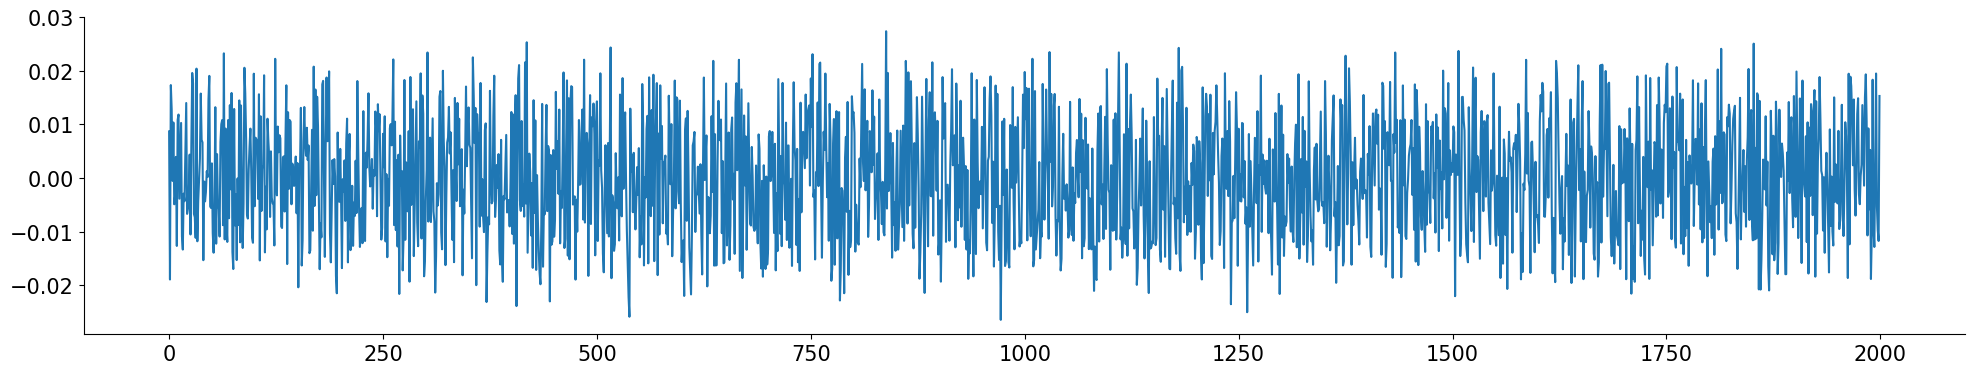

tensor(165.5497, grad_fn=<AddBackward0>)


KeyboardInterrupt: ignored

In [65]:
critic_err, generator_err = [],[]
for epoch in range(num_epochs):
    real_samples = training_data.clone().detach()
    real_samples = real_samples.reshape(46,1,2000)
    real_samples.requires_grad = True
    for _ in range(CRITIC_ITER):
        latent_space_vector = torch.randn(46,200,1)
        fake_samples = generator(latent_space_vector)
        critic_real = critic(real_samples).reshape(-1)
        critic_fake = critic(fake_samples).reshape(-1)
        gp = gradient_penalty(critic,real_samples,fake_samples)
        loss_critic = (-(torch.mean(critic_real)-torch.mean(critic_fake))+ LAMBDA_GP*gp)
        critic.zero_grad()
        loss_critic.backward(retain_graph=True)
        print(loss_critic)
        optimizer_critic.step()
    output = critic(fake_samples).reshape(-1)
    loss_generator = -torch.mean(output)
    generator.zero_grad()
    loss_generator.backward()
    optimizer_generator.step()
    print(real_samples,fake_samples)
    plt.plot(torch.arange(2000),fake_samples[0][0].detach())
    plt.show()
    critic_err.append(loss_critic.item())
    generator_err.append(loss_generator.item())


